# Rules of the Easy 21 game

We'll implement the tasks described at the [Easy 21 assignment](http://www0.cs.ucl.ac.uk/staff/d.silver/web/Teaching_files/Easy21-Johannes.pdf).

* The game is played with an infinite deck of cards (i.e. cards are sampled with replacement)
* Each draw from the deck results in a value between 1 and 10 (uniformly distributed) with a colour of red (probability 1/3) or black (probability 2/3)
* There are no aces or picture (face) cards in this game
* At the start of the game both the player and the dealer draw one black card (fully observed)
* Each turn the player may either stick or hit
* If the player hits then she draws another card from the deck
* If the player sticks she receives no further cards
* The values of the player’s cards are added (black cards) or subtracted (red cards)
* If the player’s sum exceeds 21, or becomes less than 1, then she “goes bust” and loses the game (reward -1)
* If the player sticks then the dealer starts taking turns. The dealer always sticks on any sum of 17 or greater, and hits otherwise. If the dealer goes bust, then the player wins; otherwise, the outcome – win (reward +1), lose (reward -1), or draw (reward 0) – is the player with the largest sum.

> **All the code is commented and is intended to be a good place for beginners to get started with RL.**

## Dependencies

In [30]:
import numpy as np # for vectors manipulation

import matplotlib.pyplot as plt  # for plotting beautiful graphs
import matplotlib
from mpl_toolkits.mplot3d import Axes3D  # in 3D
%matplotlib inline

import random  # for generating random values
from enum import Enum  # for represeting things like card value or colors

import copy  # copy Python objects

## Plot code

This is just for making plots, skip this section if you want to.

In [31]:
def plot_value_function(V, title="Value Function"):
    """ Plots the value function as a surface plot. """

    # min value allowed accordingly with the doc is 1
    # max value we're getting from the dimensions of V
    min_x = 1
    max_x = V.shape[0]
    
    min_y = 1
    max_y = V.shape[1]

    # this creates a sequence from min to max
    x_range = np.arange(min_x, max_x)
    y_range = np.arange(min_y, max_y)
    
    # this creates a grid representation of x_range and y_range
    X, Y = np.meshgrid(x_range, y_range)

    # Find value for all (x, y) coordinates
    def get_value(state):
        """Return V value of a given state"""
        return V[state[0]][state[1]]
   
    Z = np.apply_along_axis(get_value, 2, np.dstack([X, Y]))

    def plot_surface(X, Y, Z, title):
        fig = plt.figure(figsize=(20, 10))
        ax = fig.add_subplot(111, projection='3d')
        surf = ax.plot_surface(Y, X, Z, rstride=1, cstride=1,
                               cmap=matplotlib.cm.coolwarm, vmin=-1.0, vmax=1.0)
        ax.set_xlabel('Player Sum')
        ax.set_ylabel('Dealer Showing')
        ax.set_zlabel('Value')
        ax.set_title(title)
        ax.view_init(ax.elev, -120)
        fig.colorbar(surf)
        plt.show()

    plot_surface(X, Y, Z, "{}".format(title))

## Task 1 and 2: Game Implementation + Monte Carlo Control

You should write an environment that implements the game Easy21.

Specifically, write a **function, named step, which takes as input a state s (dealer’s first
card 1–10 and the player’s sum 1–21), and an action a (hit or stick), and returns
a sample of the next state s (which may be terminal if the game is finished) and reward r.**

We will be using this environment for model-free reinforcement learning, and you should not explicitly represent the transition matrix for the MDP. There is no discounting (γ = 1).

You should treat the dealer’s moves as part of the environment, i.e. calling step with a stick action will play out the dealer’s cards and return the final reward and terminal state.

Then apply Monte-Carlo control to Easy21.

### Deck

In [32]:
class Color(Enum):
    RED = 0
    BLACK = 1
    def __int__(self):
        return self.value

class Card(object):
        
    def __init__(self, color=None):
        self.value = self._get_random_value()
        if color == Color.BLACK or color == Color.RED:
            self.color = color
        else:
            self.color = self._get_random_color()

    def _get_random_value(self):
        '''
            Generates integers between 1 and 10.
        '''
        return random.randint(1, 10)
    
    def _get_random_color(self):
        '''
            Generates random colors.
            Color.RED with 1/3 and Color.BLACK with 2/3 probability.
        '''
        random_number = random.random()
        if random_number > 1/3.0:
            return Color.BLACK
        else:
            return Color.RED


class Deck(object):
  
    def __init__(self):
        return
    
    def get_card(self, color=None):
        return Card(color)

### State and Action

In [33]:
class State(object):
    
    dealer_sum = 0
    agent_sum = 0
    is_terminal = False
    
    def __init__(self, dealer_sum=0, agent_sum=0, is_terminal=False):
        self.dealer_sum = dealer_sum
        self.agent_sum = agent_sum
        self.is_terminal = is_terminal

    def update(self, dealer_sum, agent_sum, is_terminal):
        self.dealer_sum = dealer_sum
        self.agent_sum = agent_sum
        self.is_terminal = is_terminal

class Action(Enum):
    STICK = 0
    HIT = 1

### Agent and Dealer

In [54]:
DEALERS_SUM = 11
AGENT_SUM = 22
NUM_ACTIONS = 2

class Player(object):
    
    value_sum = 0
    
    def __init__(self):
        self.value_sum = 0
     
    def get_card(self, deck, card_color=None):
        Card = deck.get_card(card_color)
        if Card.color == Color.BLACK:
            self.value_sum += Card.value
        else:
            self.value_sum -= Card.value
        
        return self.value_sum
    
    def policy(self, cur_state, deck):
        '''Given a state and a deck of cards available choose an action'''
        action = None
        return action

    
class Dealer(Player):
    
    value_sum = 0
    
    def __init__(self):
        Player.__init__(self)
        self.value_sum = 0

    def policy(self, cur_state, deck):
        if self.value_sum >= 17:
            return Action.STICK
        else:
            self.get_card(deck)
            return Action.HIT

class Q_function(object):
    
    def __init__(self):
        self.q = np.zeros([DEALERS_SUM, AGENT_SUM, NUM_ACTIONS])
        
    def get_best_actions(self):
        return np.argmax(self.q, axis=2)
 
    def get_all_actions_state(self, state):
        return self.get_all_actions(state.dealer_sum, state.agent_sum)
    
    def get_all_actions(self, d_sum, a_sum):
        return self.q[d_sum][a_sum]
    
    def get_best_action_state(self, state):
        return self.get_best_action(state.dealer_sum, state.agent_sum)
    
    def get_best_action(self, d_sum, a_sum):
        return Action.HIT if np.argmax(self.q[d_sum][a_sum]) == 1 else Action.STICK

    def get_max_action(self, d_sum, a_sum):
        return np.max(self.q[d_sum][a_sum])
    
    def improve_value_function(self, e, state):
        return (e/2.0) * np.sum(self.get_all_actions_state(state)) + (1 - e) * (self.get_best_action_state(state)).value 
    
    def predict_state(self, alpha, state, action, Gt):
        d_sum = state.dealer_sum
        a_sum = state.agent_sum
        error = Gt - self.q[d_sum][a_sum][action]
        self.q[d_sum][a_sum][action] += alpha * error

class Agent(Player):
    
    def __init__(self, No = 100):
        Player.__init__(self)
        self.No = No
        self.Q = Q_function()
        self.N_s = np.zeros([DEALERS_SUM, AGENT_SUM])
        self.N_s_a = np.zeros([DEALERS_SUM, AGENT_SUM, NUM_ACTIONS])
        self.V = np.zeros([DEALERS_SUM, AGENT_SUM])
        self.returns_sum = np.zeros([DEALERS_SUM, AGENT_SUM])
        self.discount_factor = 1
        
    def get_alpha(self, cur_state, action):
        '''αt = 1/N(st, at)'''
        return 1.0/(self.N_s_a[cur_state.dealer_sum][cur_state.agent_sum][action])
    
    def get_e(self, cur_state):
        '''et = N0/(N0 + N(st))'''
        return self.No/(self.No + self.N_s[cur_state.dealer_sum][cur_state.agent_sum])
    
    def get_value_function(self):
        '''Get best value function in the moment.'''
        for i in xrange(self.N_s.shape[0]):
            for j in xrange(self.N_s.shape[1]):
                self.V[i][j] = self.Q.get_max_action(i, j)
        return self.V
    
    def get_random_action(self):
        return Action.HIT if random.random() <= 1/2.0 else Action.STICK

    def policy(self, cur_state, deck):
        if random.random() <= self.get_e(cur_state)/2.0:
            return self.get_random_action()
        else:
            return self.Q.get_best_action_state(cur_state)
        '''
        if self.value_sum >= 17:
            return Action.STICK
        else:
            self.get_card(deck)
            return Action.HIT
        '''
    def control(self):
        '''Improve the value function.'''
        for i in xrange(self.N_s.shape[0]):
            for j in xrange(self.N_s.shape[1]):
                state = State(i, j)
                self.V[i][j] = self.Q.improve_value_function(self.get_e(state), state)

    def predict(self, experience, G):
        '''Given a experience and a return G. Improve the value function approximation.'''
        for state, action, _ in experience:
            d_sum = state.dealer_sum
            a_sum = state.agent_sum
            self.N_s[d_sum][a_sum] += 1
            self.N_s_a[d_sum][a_sum][action] += 1
            # G = sum([x[2]*(self.discount_factor**i) for i,x in enumerate(episode[first_occurence_idx:])])
            self.Q.predict_state(self.get_alpha(state, action), state, action, G)
            '''
            self.returns_sum[d_sum][a_sum] += G
            self.V[d_sum][a_sum] = self.returns_sum[d_sum][a_sum] / self.N_s[d_sum][a_sum]
            '''

### Environment and Game

In [55]:
class Environment(object):
    
    def __init__(self):
        self.dealer = Dealer()
        self.deck = Deck()
   
    def _check_bust(self, player_sum):
        return player_sum <= 1 or player_sum > 21
    
    def _get_reward_no_bust(self, cur_state):
        if agent.value_sum > self.dealer.value_sum:
            return 1
        elif agent.value_sum == self.dealer.value_sum:
            return 0
        else:
            return -1
        
    def dealer_turn(self, cur_state):
        action = None
        while not cur_state.is_terminal and action != Action.STICK:
            action = self.dealer.policy(cur_state, self.deck)
            cur_state.update(self.dealer.value_sum, cur_state.agent_sum, self._check_bust(self.dealer.value_sum))
        return cur_state
    
    def step(self, action, cur_state, agent):
        reward = 0
        if action == Action.STICK:
            cur_state = self.dealer_turn(cur_state)
            # if end of the game after dealer's turn reward = 1
            if cur_state.is_terminal:
                reward = 1
            else:
                cur_state.update(cur_state.dealer_sum, cur_state.agent_sum, True)
                reward = self._get_reward_no_bust(cur_state)
            
            return cur_state, reward           
        else:
            agent.get_card(self.deck)
            cur_state.update(self.dealer.value_sum, agent.value_sum, self._check_bust(agent.value_sum))

            # if end of the game, reward = -1
            if cur_state.is_terminal:
                reward = -1


            return cur_state, reward

    def initial_step(self, agent):
        
        # first set sums to 0
        agent.value_sum = 0
        self.dealer.value_sum = 0
        
        # then the agent and dealer get a black card
        agent.get_card(self.deck, Color.BLACK)
        self.dealer.get_card(self.deck, Color.BLACK)

    def run_steps(self, agent):
        # then the game goes on until it gets to a final state
        action = None
        reward = 0
        experience = []
        cur_state = State(self.dealer.value_sum, agent.value_sum, False)
        while not cur_state.is_terminal:
            action = agent.policy(cur_state, self.deck)
            experience.append((copy.copy(cur_state), action.value, None))
            cur_state, reward = self.step(action, cur_state, agent)

        return experience, reward
    
    def run_episode(self, agent):
        '''
            Given a agent policy returns a reward.
        '''
        
        self.initial_step(agent)
        experience, reward = self.run_steps(agent)
        agent.predict(experience, reward)
        # agent.control()

In [64]:
agent = Agent()
environment = Environment()

for i in xrange(100000):
    environment.run_episode(agent)
    if i % 1000 == 0:
        print '%d/%d' % (i, 200000)

0/200000
1000/200000
2000/200000
3000/200000
4000/200000
5000/200000
6000/200000
7000/200000
8000/200000
9000/200000
10000/200000
11000/200000
12000/200000
13000/200000
14000/200000
15000/200000
16000/200000
17000/200000
18000/200000
19000/200000
20000/200000
21000/200000
22000/200000
23000/200000
24000/200000
25000/200000
26000/200000
27000/200000
28000/200000
29000/200000
30000/200000
31000/200000
32000/200000
33000/200000
34000/200000
35000/200000
36000/200000
37000/200000
38000/200000
39000/200000
40000/200000
41000/200000
42000/200000
43000/200000
44000/200000
45000/200000
46000/200000
47000/200000
48000/200000
49000/200000
50000/200000
51000/200000
52000/200000
53000/200000
54000/200000
55000/200000
56000/200000
57000/200000
58000/200000
59000/200000
60000/200000
61000/200000
62000/200000
63000/200000
64000/200000
65000/200000
66000/200000
67000/200000
68000/200000
69000/200000
70000/200000
71000/200000
72000/200000
73000/200000
74000/200000
75000/200000
76000/200000
77000/200000

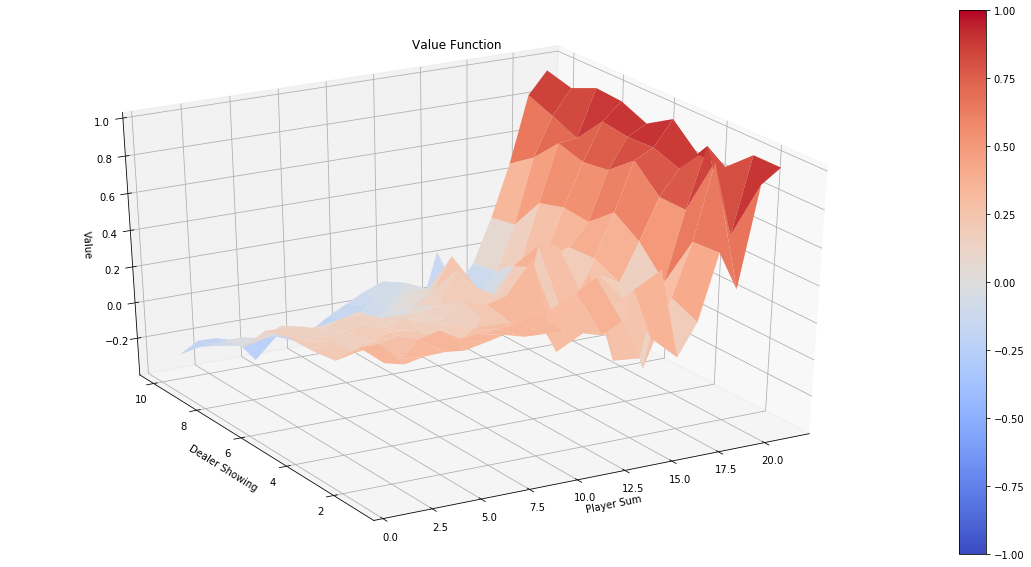

In [65]:

plot_value_function(agent.get_value_function())